# PSS3- Logistic Regression on Employee turnover(churn) data
The following notebook provides an example code of analyzing Employee turnover(churn) using logistic regression. The dependent variable is Churn (1-yes, 0-no).


The general sequence of steps for the analysis the following:

1. Descriptive analysis
2. Modelling (creating dummies, train test split)
3. Logistic regression construction and interpretation (log odds, marginal effects)

 ## 1. Descriptive analysis
 
The initial data consists of 14999 observations of 10 variables.There are 3008 duplicates in data, however we will Not drop them, as there is no employee ID or some uniquely defined variable using which we can identify each employee. In short, there might be just people having similar postitions, salary etc. Data overview hints that there are continuous (satisfaction_level,last_evaluation,average_montly_hours etc.), binary(promotion_last_5years,work_accident) and categorical (department, salary) features. Employee churn is not evenly balanced between 0s and 1s. As the countplot and value counts show, only about 23% of employees are leaving and ~76% are staying.So we can use this info as a naive assumption for newcomers to decide whether they'll leave or stay. In other words, if the resulting score is more than the noted value, then our model will be not bad, otherwise-a bad one.

We also outlined several questions answers of can be observed visually.

-Is there a relationship between satisfaction level, salary and churn? 

-What is the salary rate distribution by departments?

-Which departments have the highest/lowest churn rate?

The visualization shows that employee churn is connected with the satisfaction level. The boxplot shows that employees who left are on average less satisfied with the job, regardless of the salary. The highest paid department is management and it is also the one having highest staying rate. The lowest salary rate is at support department. HR is the department having hisghest churn rate.

In case of logistic regression when constructing a heatmap we are mostly interested in identifying correlations between independent variables, as the target is binary and correlation between Y and X-s is not represenative in this case. The highest correlation is between average montly hours and number of projects (corr. coefficient is 0.42), which is logical as the more projects there are, the more time you spend for their implementation. Next comes number of projects and last evaluation, with 0.35 correlation coefficient.

In [1]:
import pandas as pd #to read and manipulate
import numpy as np #to have math functions available 

from statsmodels.discrete.discrete_model import Logit #to run logistic regression. 
#OR 
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import * #star means all metrics, so it imports all possible scores
import statsmodels.tools as sm


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("turnover_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'turnover_data.csv'

In [3]:
data.head(2)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,churn,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium


In [4]:
#information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   churn                  14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
#make the datatype of binary variables to categorical
data.work_accident = pd.Categorical(data.work_accident)
data.promotion_last_5years = pd.Categorical(data.promotion_last_5years)


In [6]:
#how many rows we have in the dataset
data.shape

(14999, 10)

In [7]:
#how many unique departments
data.department.unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [8]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:",data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns", data.columns[data.nunid(que()==True])

Duplicates: 3008
Missing values: 0
Single valued columns Index([], dtype='object')


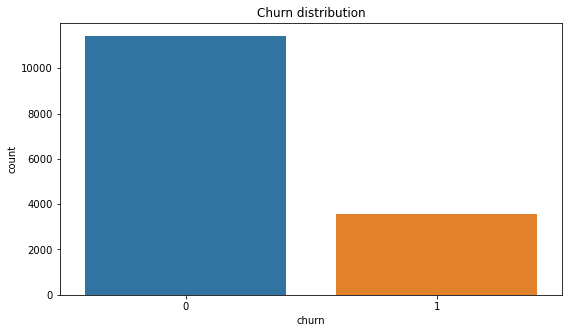

In [9]:
#let's visualise the distribution of churn
plt.figure(figsize=(9,5))
sns.countplot(data.churn)
plt.title("Churn distribution")
plt.show()

In [10]:
#lets count the benchmark for employee churn
data.churn.value_counts(normalize = True) #Getting proportions fo each category in whole. 

0    0.761917
1    0.238083
Name: churn, dtype: float64

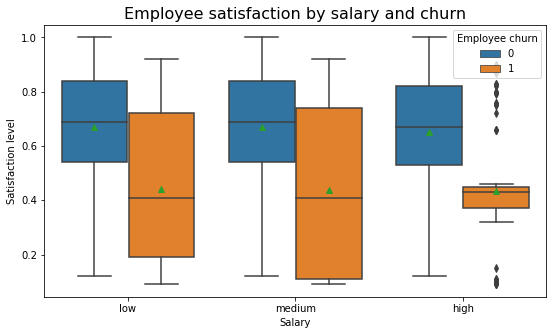

In [11]:
#Let's see the relationship of salary and satisfaction level via boxplot
plt.figure(figsize=(9,5))
sns.boxplot(x="salary", y="satisfaction_level", data=data, showmeans=True, hue="churn")
plt.legend(title='Employee churn', loc='upper right')
plt.xlabel("Salary")
plt.ylabel("Satisfaction level")
plt.title("Employee satisfaction by salary and churn",fontdict={"fontsize":16})
plt.show()

In [3]:
#creating churn rate and salary rate
#data using groupby. parameter: "normalize"in value_counts() returns relative frequencies, "mul" multiplies by noted number
#(in this case-100,to get %)
churn_rate=data.groupby("department")["churn"].value_counts(normalize=True).rename("percentage").mul(100).reset_index()
salary_rate=data.groupby("department")["salary"].value_counts(normalize=True).rename("percentage").mul(100).reset_index()

NameError: name 'data' is not defined

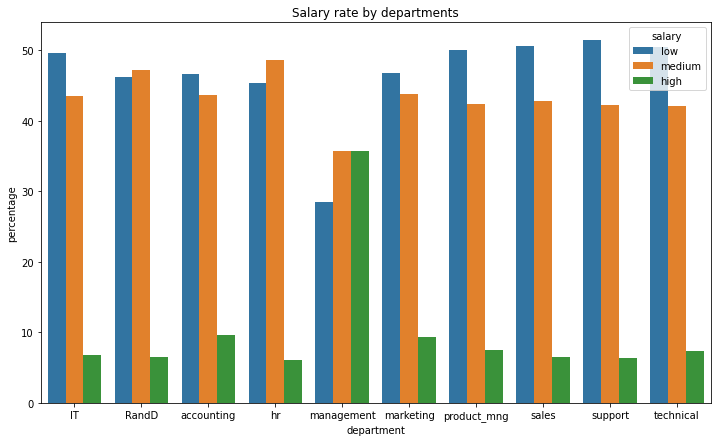

In [13]:
#Salary rate by departments
plt.figure(figsize=(12,7))
sns.barplot(x="department", y="percentage", hue="salary", data=salary_rate)
plt.title("Salary rate by departments")
plt.show()

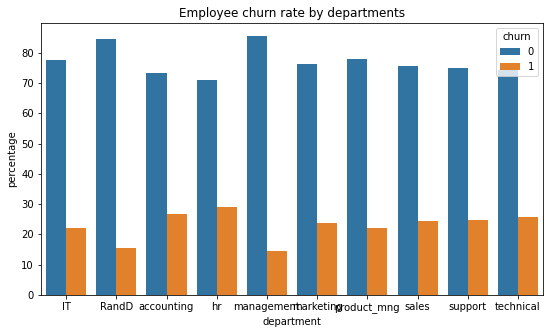

In [14]:
#Employee churn rate by departments
plt.figure(figsize=(9,5))
sns.barplot(x="department",y="percentage", hue="churn",data=churn_rate)
plt.title("Employee churn rate by departments")
plt.show()

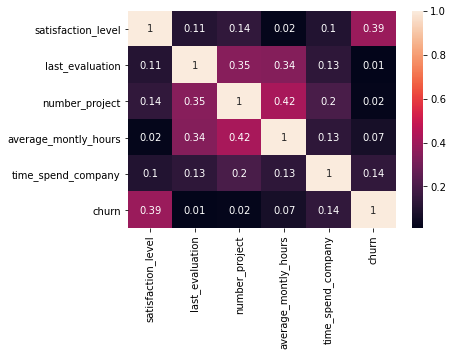

In [15]:
#heatmap
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

In [16]:
#mean satisfaction level by  salary group 
data.groupby(by = "salary")["satisfaction_level"].mean()

salary
high      0.637470
low       0.600753
medium    0.621817
Name: satisfaction_level, dtype: float64

In [17]:
#mean satisfaction level by department group 
data.groupby(by = "department")["satisfaction_level"].mean()

department
IT             0.618142
RandD          0.619822
accounting     0.582151
hr             0.598809
management     0.621349
marketing      0.618601
product_mng    0.619634
sales          0.614447
support        0.618300
technical      0.607897
Name: satisfaction_level, dtype: float64

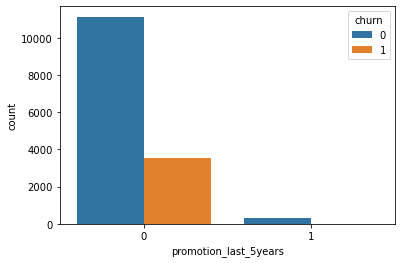

In [18]:
#countplot by the promotion in the last 5 years and churn 
sns.countplot(data.promotion_last_5years, hue = data.churn)
plt.showgar

In [4]:
#converting the variable to log scale 
data["time_spend_company"] = np.log1p(data["time_spend_company"])

NameError: name 'data' is not defined

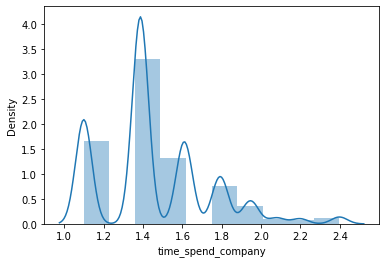

In [20]:
#THe dsitribution of time_spend_company variable is made more normal by loging it. 
#distribution of time_spend_company 
sns.distplot(data.time_spend_company, bins=10)
plt.show()

## 2. Modelling


In [21]:
Y = data.churn
X = data.drop("churn", axis = 1)

In [22]:
X = pd.get_dummies(X, drop_first=True)

In [23]:
X0, X1, Y0, Y1 = train_test_split(X,Y, random_state = 42, test_size = 0.25)

## 3. Logistic regression construction and interpretation 

In [24]:
Logistic = LogisticRegression(random_state = 10)
results = Logistic.fit(X0,Y0)
train_y_new = Logistic.predict(X0)
test_y_new = Logistic.predict(X1)

In [25]:
train_acc = accuracy_score(Y0,train_y_new)
test_acc = accuracy_score(Y1,test_y_new)

train_recall = recall_score(Y0,train_y_new)
test_recall = recall_score(Y1,test_y_new)

train_prec = precision_score(Y0,train_y_new)
test_prec = precision_score(Y1,test_y_new)

In [26]:
indx = [ 'Acc_train', 'Acc_test', "Recall_train", 'Recall_test', "Precision_train", 'Precision_test']
results = pd.DataFrame(index=indx, columns=['Logistic'])
name = results.columns[0]
results[name] = [train_acc, test_acc, train_recall, test_recall, train_prec, test_prec]

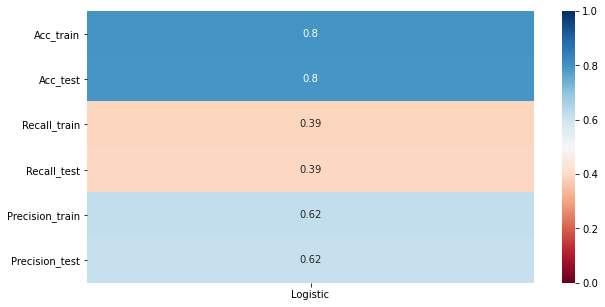

In [27]:
plt.figure(figsize = (10, 5))
s = sns.heatmap(results,
               annot = True, 
               cmap = 'RdBu',
               vmin = 0, 
               vmax = 1)

Recall (also known as sensitivity) is the measure of a model's ability to correctly identify all positive instances in a dataset.It is calculated as the ratio of true positive predictions to the total number of actual positive instances in the dataset.\
Precision is the measure of a model's ability to correctly identify only the positive instances in a dataset. It is calculated as the ratio of true positive predictions to the total number of positive predictions made by the model.


## 4. Logistic regression model (log odds, marginal effects)
We will construct the model based on statsmodels.api library, meaning will fit the data on training set and evaluate both for training and testing sets.

In [28]:
#as we are going to use not formula but X and Y data in the logit function, 
#so we need to add the intercept to data (X) manually
X=sm.add_constant(X)

In [29]:
X0, X1, Y0, Y1 = train_test_split(X,Y, random_state = 42, test_size = 0.25)

In [30]:
model = Logit(Y0,X0)

In [31]:
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.418248
         Iterations 7


In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                11249
Model:                          Logit   Df Residuals:                    11230
Method:                           MLE   Df Model:                           18
Date:                Sat, 25 Mar 2023   Pseudo R-squ.:                  0.2374
Time:                        15:38:46   Log-Likelihood:                -4704.9
converged:                       True   LL-Null:                       -6169.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.5165      0.253    -13.924      0.000      -4.012      -3.022
satisfaction_level         -4.1386      0.114    -36.220      0.000      -4.363      -3.915
last_evaluation             0.5948      0.175      3.403      0.001       0.252       0.937
number_project             -0.3392      0.025    -13.554      0.000      -0.388      -0.290
average_montly_hours        0.0046      0.001      7.545      0.000       0.003       0.006
time_spend_company          1.9687      0.100     19.681      0.000       1.773       2.165
work_accident_1            -1.5344      0.104    -14.761      0.000      -1.738      -1.331
promotion_last_5years_1    -1.4213      0.293     -4.856      0.000      -1.995      -0.848
department_RandD           -0.5887      0.163     -3.607      0.000      -0.909      -0.269
department_accounting       0.1118      0.143      0.782      0.434      -0.168       0.392
department_hr               0.4101      0.143      2.864      0.004       0.129       0.691
department_management      -0.2815      0.173     -1.624      0.104      -0.621       0.058
department_marketing        0.1892      0.143      1.323      0.186      -0.091       0.470
department_product_mng      0.0737      0.138      0.535      0.593      -0.196       0.344
department_sales            0.1340      0.104      1.284      0.199      -0.071       0.338
department_support          0.1945      0.114      1.705      0.088      -0.029       0.418
department_technical        0.2576      0.110      2.342      0.019       0.042       0.473
salary_low                  1.9956      0.152     13.107      0.000       1.697       2.294
salary_medium               1.4903      0.153      9.736      0.000       1.190       1.790
===========================================================================================
"""

The z here is not the intermiediate value. 

For a one-unit increase in satisfaction_level we expect on average a 4.1914 decrease in the log-odds of churn, holding all other independent variables constant.

For employees with low salaries, we expect on average a 1.9639 increase in the log-odds of the dependent variable churn compared to the employees with high salaries.

As we want to interpret probabilites, let's get marginal effects.

In [33]:
results.get_margeff().summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  churn
Method:                          dydx
At:                           overall
===========================================================================================
                             dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
satisfaction_level         -0.5558      0.012    -47.057      0.000      -0.579      -0.533
last_evaluation             0.0799      0.023      3.408      0.001       0.034       0.126
number_project             -0.0456      0.003    -13.864      0.000      -0.052      -0.039
average_montly_hours        0.0006   8.08e-05      7.611      0.000       0.000       0.001
time_spend_company          0.2644      0.013     20.804      0.000       0.239       0.289
work_accident_1            -0.2061      0.014    -15.167      0.000      -0.233      -0.179
promotion_last_5years_1    -0.1909      0.039     -4.868      0.000      -0.268      -0.114
department_RandD           -0.0791      0.022     -3.613      0.000      -0.122      -0.036
department_accounting       0.0150      0.019      0.782      0.434      -0.023       0.053
department_hr               0.0551      0.019      2.867      0.004       0.017       0.093
department_management      -0.0378      0.023     -1.625      0.104      -0.083       0.008
department_marketing        0.0254      0.019      1.323      0.186      -0.012       0.063
department_product_mng      0.0099      0.018      0.535      0.593      -0.026       0.046
department_sales            0.0180      0.014      1.284      0.199      -0.009       0.045
department_support          0.0261      0.015      1.705      0.088      -0.004       0.056
department_technical        0.0346      0.015      2.343      0.019       0.006       0.064
salary_low                  0.2680      0.020     13.384      0.000       0.229       0.307
salary_medium               0.2002      0.020      9.839      0.000       0.160       0.240
===========================================================================================
"""

<b> An Incremental increase in satisfaction level will decrease the probability of churn on average by 57.48% when other factors are held constant.
Employees with low salary have on average 26.93% higher probability of churn compared to employees with high salaries. </b>

Next Steps: Do feature engineering and tune the model. 